# ANLP Assignment: Sentiment Classification

In this assignment, you will be investigating NLP methods for distinguishing positive and negative reviews written about movies.

For assessment, you are expected to complete and submit this notebook file.  When answers require code, you may import and use library functions (unless explicitly told otherwise).  All of your own code should be included in the notebook rather than imported from elsewhere.  Written answers should also be included in the notebook.  You should insert as many extra cells as you want and change the type between code and markdown as appropriate.

In order to avoid misconduct, you should not talk about the assignment questions with your peers.  If you are not sure what a question is asking you to do or have any other questions, please ask me or one of the Teaching Assistants.

Marking guidelines are provided as a separate document.

The first few cells contain code to set-up the assignment and bring in some data.   In order to provide unique datasets for analysis by different students, you must enter your candidate number in the following cell.  Otherwise do not change the code in these cells.

In [1]:
candidateno=277269 #this MUST be updated to your candidate number so that you get a unique data sample

In [2]:
#do not change the code in this cell
#preliminary imports

#set up nltk
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('movie_reviews')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.corpus import movie_reviews

#for setting up training and testing data
import random

#useful other tools
import re
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from itertools import zip_longest
from nltk.probability import FreqDist
from nltk.classify.api import ClassifierI


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/thanhnguyen/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/thanhnguyen/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package movie_reviews to
[nltk_data]     /Users/thanhnguyen/nltk_data...
[nltk_data]   Unzipping corpora/movie_reviews.zip.


In [3]:
#do not change the code in this cell
def split_data(data, ratio=0.7): # when the second argument is not given, it defaults to 0.7
    """
    Given corpus generator and ratio:
     - partitions the corpus into training data and test data, where the proportion in train is ratio,

    :param data: A corpus generator.
    :param ratio: The proportion of training documents (default 0.7)
    :return: a pair (tuple) of lists where the first element of the
            pair is a list of the training data and the second is a list of the test data.
    """

    data = list(data)
    n = len(data)
    train_indices = random.sample(range(n), int(n * ratio))
    test_indices = list(set(range(n)) - set(train_indices))
    train = [data[i] for i in train_indices]
    test = [data[i] for i in test_indices]
    return (train, test)


def get_train_test_data():

    #get ids of positive and negative movie reviews
    pos_review_ids=movie_reviews.fileids('pos')
    neg_review_ids=movie_reviews.fileids('neg')

    #split positive and negative data into training and testing sets
    pos_train_ids, pos_test_ids = split_data(pos_review_ids)
    neg_train_ids, neg_test_ids = split_data(neg_review_ids)
    #add labels to the data and concatenate
    training = [(movie_reviews.words(f),'pos') for f in pos_train_ids]+[(movie_reviews.words(f),'neg') for f in neg_train_ids]
    testing = [(movie_reviews.words(f),'pos') for f in pos_test_ids]+[(movie_reviews.words(f),'neg') for f in neg_test_ids]

    return training, testing

When you have run the cell below, your unique training and testing samples will be stored in `training_data` and `testing_data`

In [4]:
#do not change the code in this cell
random.seed(candidateno)
training_data,testing_data=get_train_test_data()
print("The amount of training data is {}".format(len(training_data)))
print("The amount of testing data is {}".format(len(testing_data)))
print("The representation of a single data item is below")
print(training_data[0])

The amount of training data is 1400
The amount of testing data is 600
The representation of a single data item is below
(['we', 'all', 'know', 'the', 'fate', 'of', '"', ...], 'pos')


1)  
a) **Generate** a list of 10 content words which are representative of the positive reviews in your training data.

b) **Generate** a list of 10 content words which are representative of the negative reviews in your training data.

c) **Explain** what you have done and why

[20\%]

In [5]:
from nltk.stem.porter import PorterStemmer

st = PorterStemmer()
stop = stopwords.words("english")

# normalise function
def normalise(wordlist):
    filtered = []
    for token in wordlist:
        if token.isdigit() is True:
                token = "NUM"
        elif token.isalnum() is True:
            if token.isalpha() is True:
                token = token.lower()
            else:
                token = "Nth"
        else:
            token = token
        token = st.stem(token)
        if token.isalpha() and token not in stop: 
            filtered.append(token)
        else:
            continue
    return filtered

training_norm=[(FreqDist(normalise(wordlist)),label) for (wordlist,label) in training_data]
testing_norm=[(FreqDist(normalise(wordlist)),label) for (wordlist,label) in testing_data]

In [6]:
pos_freq_dist=FreqDist()
neg_freq_dist=FreqDist()

for review,label in training_norm:
    if label=='pos':
        pos_freq_dist+=review
    else:
        neg_freq_dist+=review

pos_word_list = [word for (word, freq) in (pos_freq_dist-neg_freq_dist).most_common(10)]
neg_word_list = [word for (word,freq) in (neg_freq_dist-pos_freq_dist).most_common(10)]

In [7]:
print("A list of 10 content words which are representative of the positive reviews")
print(pos_word_list)

print("\n")

print("A list of 10 content words which are representative of the negative reviews")
print(neg_word_list)

A list of 10 content words which are representative of the positive reviews
['hi', 'film', 'life', 'ha', 'also', 'perform', 'great', 'one', 'veri', 'world']


A list of 10 content words which are representative of the negative reviews
['bad', 'movi', 'plot', 'whi', 'stupid', 'worst', 'wast', 'bore', 'could', 'look']


**1c) - Explanation**
- First, define a function called `normalise` to normalise every review. The function includes:
    - case normalisation 
    - number normalisation 
    - stemming using `PorterStemmer` library
    - removing stop words and punctuation
<br></br>
- Then, use the `normalise` function and `FreqDist()` library to normalise and create frequency distribution for each review. The results from training and testing data sets are stored in `training_norm` and `testing_norm`.

- Next, create two bags of words `pos_freq_dist` and `neg_freq_dist` for the positive segment and negative segment respectively by adding each review's `FreqDist()` to each segment's `FreqDist()` based on the labels

- Subtract a bag of words from the other one to get the lists of words ordered by how much more they occur in `pos_freq_dist` than `neg_freq_dist` and vice versa. Generate the top 10 words of each list by using the `most_common(10)` method.

2)
a) **Use** the lists generated in Q1 to build a **word list classifier** which will classify reviews as being positive or negative.

b) **Explain** what you have done.

[12.5\%]


In [8]:
class WLClassifier(ClassifierI):

    def __init__(self, pos, neg): 
        self._pos = pos 
        self._neg = neg 

    def classify(self, doc): 
        #doc is a FreqDist
        score = 0
        for word,count in doc.items():
            if word in self._pos:
                score += count
            if word in self._neg:
                score -= count
        if score > 0:
            return "pos"
        elif score < 0:
            return "neg"
        else:
            return random.choice(["pos", "neg"])

    def labels(self): 
        return ("pos", "neg")

word_list_classifier = WLClassifier(pos_word_list, neg_word_list)

**2b) - Explanation**
- First, define a class named `WLClassifier`. This class inherits from the `ClassifierI` class imported from `nltk.classify.api`.

- Define the `__init__` function to take positive word list and negative word list as arguments `pos` and `neg`

- Define the `classify` function that takes a document as input and returns the output "pos" or "neg" based on the document's score:
    - The document's score starts at 0, increases for each word in the positive word list, and decreases for each word in the negative word list. The increased/decreased amount is the count of that word
    - If the total document's score is 0, then random between "pos" and "neg" labels
<br></br>
- Create a `WLClassifier` object named `word_list_classifier` with `pos_word_list` and `neg_word_list` from Q1 as arguments

3)
a) **Calculate** the accuracy, precision, recall and F1 score of your classifier.

b) Is it reasonable to evaluate the classifier in terms of its accuracy?  **Explain** your answer and give a counter-example (a scenario where it would / would not be reasonable to evaluate the classifier in terms of its accuracy).

[20\%]

In [9]:
class ConfusionMatrix:

    def __init__(self,predictions,goldstandard,classes=("pos","neg")):
        (self.c1,self.c2)=classes
        self.TP=0
        self.FP=0
        self.FN=0
        self.TN=0
        for p,g in zip(predictions,goldstandard):
            if g==self.c1:
                if p==self.c1:
                    self.TP+=1
                else:
                    self.FN+=1
            elif p==self.c1:
                self.FP+=1
            else:
                self.TN+=1

    def accuracy(self):
        a = (self.TP + self.TN) / (self.TP + self.TN + self.FP + self.FN)
        return a

    def precision(self):
        p = self.TP / (self.TP + self.FP)
        return p

    def recall(self):
        r = self.TP / (self.TP + self.FN)
        return r

    def f1(self):
        p = self.precision()
        r = self.recall()
        f1 = 2*p*r/(p+r)
        return f1


In [10]:
docs,labels = zip(*testing_norm)
word_list_predictions = word_list_classifier.classify_many(docs)

In [11]:
word_list_score = ConfusionMatrix(predictions=word_list_predictions, goldstandard=labels)

print(f"The accuracy of the word_list_classifier is {word_list_score.accuracy()}")
print(f"The precision of the word_list_classifier is {word_list_score.precision()}")
print(f"The recall of the word_list_classifier is {word_list_score.recall()}")
print(f"The f1_score of the word_list_classifier is {word_list_score.f1()}")

The accuracy of the word_list_classifier is 0.5666666666666667
The precision of the word_list_classifier is 0.5387596899224806
The recall of the word_list_classifier is 0.9266666666666666
The f1_score of the word_list_classifier is 0.6813725490196078


In [12]:
#calculate the ratio of positive review and negative review in testing data
pos_ratio = sum(True for label in labels if label == "pos") / len(labels)
pos_ratio

0.5

**3b) - Answer**
- In general, it is reasonable to initially evaluate a model based on its `accuracy`. Whether we want a higher `precision`  or `recall`, they are all related to `accuracy`.

- However, the `accuracy` of a model could be unreliable if our classes' sizes are unbalanced. Moreover, depending on requirements and context, we need to calculate other scores like `precision` or `recall` to evaluate whether our model is good enough.

- Real scenarios:
    - User retention after 7 days of a mobile game tends to be around 10%. Let's say we need to identify users who will play for more than 7 days for a special event to boost their purchases. It is easy to get a 90% `accuracy` if we predict all the users will churn. But then our `recall` will be 0, and we have no customers for the campaign. So we need to maximize the `recall` because we should run the campaign on all users likely to play more than 7 days, even if they're not. Here is when `recall` becomes more critical than `accuracy`.
    - On the other hand, the `word_list_classifier` above has the `recall` at 0.93 approximately, but its `accuracy` is only 56%. We can quickly get a 100% `recall` if we predict all the review is positive. But, if the ratio between positive reviews and negative reviews in testing data is 50:50 (as calculated above), then the `accuracy` and `precision` will be only 50%, which is not the case we want. We want to segment the reviews, whether positive or negative, as accurately as possible rather than assume all of them are positive. And it is clear that the `word_list_classifier` does not perform well when its `accuracy` is only slightly higher than 50%.

4)
a)  **Construct** a Naive Bayes classifier (e.g., from NLTK).

b)  **Compare** the performance of your word list classifier with the Naive Bayes classifier.  **Discuss** your results.

[12.5\%]

In [13]:
import numpy as np

class NBClassifier(ClassifierI):

    def __init__(self):
        pass

    # create a known vocabulary for smoothing
    def _set_known_vocabulary(self,training_data):
        known = []
        for doc,label in training_data:
            known += list(doc.keys())
        self.known = set(known)

    # calculate the prior probability of a class
    def _set_priors(self,training_data):
        classes = {}
        for i in training_data:
            classes[i[1]] = classes.get(i[1],0) + 1
        sum_class = sum(value for value in classes.values())
        for c in classes:
            classes[c] = classes[c]/sum_class
        self.priors = classes

    # compute the conditional probability of a document
    def _set_cond_probs(self,training_data):       
        cond_probs = {}
        for s,c in training_data:
            cond_probs[c] = cond_probs.get(c,FreqDist({})) + s
        for c in cond_probs:
            for w in self.known:
                cond_probs[c][w] = cond_probs[c].get(w,0) + 1 # add-one smoothing
        for c in cond_probs:
            sum_word = sum(cond_probs[c].values())
            cond_probs[c] = {key:value/sum_word for key, value in cond_probs[c].items()}
        self.c_probs = cond_probs

    def train(self,training_data):
        self._set_known_vocabulary(training_data)
        self._set_priors(training_data)
        self._set_cond_probs(training_data)

    def classify(self,doc):
        # use log operation for dealing with underflow
        doc_probs={key:np.log(value) for (key,value) in self.priors.items()} 
        for c in doc_probs.keys():
            for w in doc.keys():
                if w in self.known:
                    doc_probs[c] = doc_probs[c] + np.log(self.c_probs[c].get(w,0))
        highprob=max(doc_probs.values())
        classes=[c for c in doc_probs.keys() if doc_probs[c]==highprob]
        return random.choice(classes)

In [14]:
naive_bayes_classifier = NBClassifier()
naive_bayes_classifier.train(training_norm)
navie_bayes_predictions = naive_bayes_classifier.classify_many(docs)

In [15]:
naive_bayes_score = ConfusionMatrix(predictions=navie_bayes_predictions, goldstandard=labels)

print(f"The accuracy of the naive_bayes_classifier is {naive_bayes_score.accuracy()}")
print(f"The precision of the naive_bayes_classifier is {naive_bayes_score.precision()}")
print(f"The recall of the naive_bayes_classifier is {naive_bayes_score.recall()}")
print(f"The f1_score of the naive_bayes_classifier is {naive_bayes_score.f1()}")

The accuracy of the naive_bayes_classifier is 0.84
The precision of the naive_bayes_classifier is 0.8469387755102041
The recall of the naive_bayes_classifier is 0.83
The f1_score of the naive_bayes_classifier is 0.8383838383838385


In [16]:
#calculate the ratio of positive review and negative review in word_list_prediction
wl_pos_predict_ratio = sum(True for label in word_list_predictions if label == "pos") / len(word_list_predictions)
wl_pos_predict_ratio

0.86

In [17]:
#calculate the ratio of positive review and negative review in navie_bayes_predictions
nb_pos_predict_ratio = sum(True for label in navie_bayes_predictions if label == "pos") / len(navie_bayes_predictions)
nb_pos_predict_ratio

0.49

**4b) - Answer**
- The performance of the `naive_bayes_classifier` built above is much better than the former `word_list_classifier`.

- With the ratio between positive reviews and negative reviews in testing data at 50:50, the `word_list_classifier` does not perform well when all of its `accuracy` and  `precision` are only slightly higher than 0.5, although its `recall` is ~ 0.93. As explained, we want to segment the reviews, whether they are positive or negative, as accurately as possible rather than assume all of them are positive.  
    - Calculating the ratio of positives in predictions by the `word_list_classifier`, we can see that the model predicted 86% of reviews are positive. The ratio is far from the actual ratio in testing data (0.5), and this explains why the model's `recall` was high because it assumed most of the reviews were positive. It means that the `recall` for negative reviews is very low.
    - A reason could be the way that word lists were constructed. The positive word list is the top 10 words that occur more in positive reviews rather than in negative reviews. But there is a chance that there are words that have different occurrences ranked in the top 10, although they occur a lot in both types of reviews (e.g., negatives could include "not good" or "not great"). Then, these words represent positive reviews, affecting documents' scores and indirectly making many negative reviews predicted as positives because they also appear a lot in negatives.
<br></br>
- On the other hand, despite getting lower `recall`, the `naive_bayes_classifier` performs pretty well when its `accuracy` and `precision` are quite high at 84% (even the `recall` is considerably high at 83%)
    - In more detail, the ratio between positives and negatives in its prediction is almost identical to the true ratio in testing data. It means that the high scores of the model are not affected by the assumption that all/most reviews are positive or negative.

5)
a) Design and **carry out an experiment** into the impact of the **length of the wordlists** on the wordlist classifier.  Make sure you **describe** design decisions in your experiment, include a **graph** of your results and **discuss** your conclusions.

b) Would you **recommend** a wordlist classifier or a Naive Bayes classifier for future work in this area?  **Justify** your answer.

[25\%]


**5a) - Experiment**
- To investigate the impact of the length of the word lists on the `word_list_classifier`, we are going to use the same technique to generate multiple pairs of word lists with different lengths and create a `word_list_classifier` for each pair of word lists. Then we will use these `word_list_classifier`(s) to classify the testing data and calculate their scores, including `accuracy`, `precision`, `recall`, and `f1_score`.

- Since we want our classifier to be best at review segmentation into both positive and negative classes (maximizing the True Positive + True Negative), we would pick `accuracy` as our decision score.

- Now, we will carry out an experiment with the length of the lists ranging from 10 to 150 and steps by 5. The results will be stored in a DataFrame and plotted on a line graph.

In [18]:
# scoring different word list classifiers using word lists with different lengths
experiment = []

for n in range(10, 151, 5):
    pos_word_list = [word for (word, freq) in (pos_freq_dist-neg_freq_dist).most_common(n)]
    neg_word_list = [word for (word,freq) in (neg_freq_dist-pos_freq_dist).most_common(n)]
    
    word_list_classifier = WLClassifier(pos_word_list, neg_word_list)
    word_list_predictions = word_list_classifier.classify_many(docs)
    
    word_list_score = ConfusionMatrix(predictions=word_list_predictions, goldstandard=labels)
    
    experiment.append([n, word_list_score.accuracy(), word_list_score.precision(), word_list_score.recall(), word_list_score.f1()])

In [19]:
df = pd.DataFrame(data=experiment, columns=['word_list_length', 'accuracy', 'precision', 'recall', 'f1_score'])
df

,word_list_length,accuracy,precision,recall,f1_score
0,10,0.565000,0.537864,0.923333,0.679755
1,15,0.586667,0.549242,0.966667,0.700483
2,20,0.585000,0.548023,0.970000,0.700361
3,25,0.651667,0.598698,0.920000,0.725361
4,30,0.651667,0.596603,0.936667,0.728923
5,35,0.635000,0.583162,0.946667,0.721728
6,40,0.626667,0.576923,0.950000,0.717884
7,45,0.635000,0.582822,0.950000,0.722433
8,50,0.635000,0.582485,0.953333,0.723135
9,55,0.626667,0.576305,0.956667,0.719298


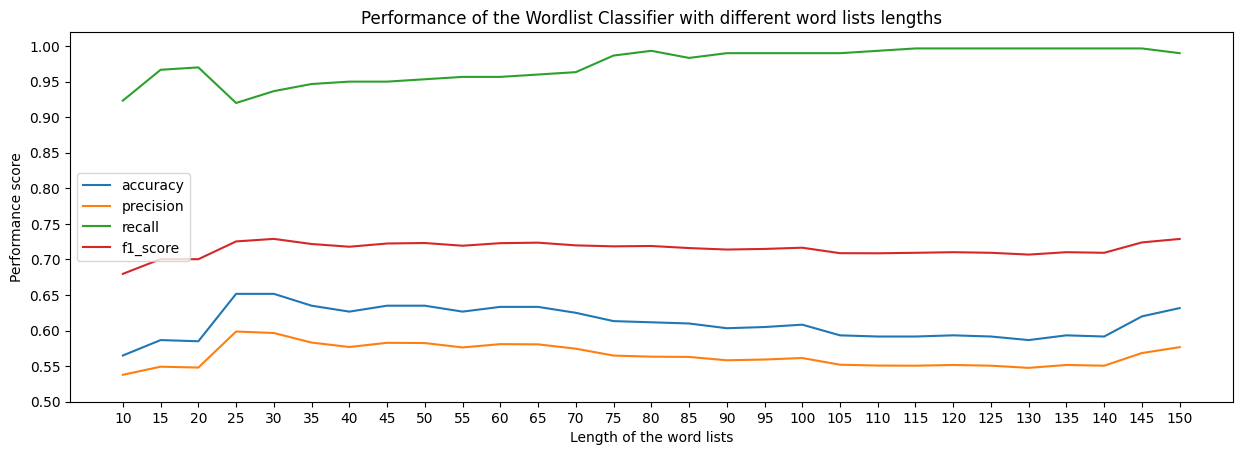

In [20]:
import matplotlib.pyplot as plt

plt.figure().set_figwidth(15)

plt.plot(df.word_list_length, df.accuracy, label="accuracy")
plt.plot(df.word_list_length, df.precision, label="precision")
plt.plot(df.word_list_length, df.recall, label="recall")
plt.plot(df.word_list_length, df.f1_score, label="f1_score")

plt.title("Performance of the Wordlist Classifier with different word lists lengths")
plt.xlabel("Length of the word lists")
plt.xticks(ticks=df.word_list_length)
plt.ylabel("Performance score")
plt.yticks(ticks=np.arange(0.5,1.01,0.05))
plt.legend(loc="best")

plt.show()

In [21]:
df[df.accuracy == df.accuracy.max()]

,word_list_length,accuracy,precision,recall,f1_score
3,25,0.651667,0.598698,0.920000,0.725361
4,30,0.651667,0.596603,0.936667,0.728923


**5a) - Answer**
- In general, the `word_list_classifier`(s)' scores varied on different word lists' lengths.

- Although the `f1_score` remained stable at around 0.7, the `precision` and `recall` fluctuated substantially and saw opposite trends since we have had a trade-off between these scores.

- Our decision score `accuracy` witnessed the same trend with `precision` as it increased and reached its peak when the lists had 25 words. When the lists' lengths passed 35 words, the `accuracy` fell slowly. In detail, we got the maximum `accuracy` at around 65%, with a pair of lists having 25 or 30 words. It seems reasonable that we needed long enough lists to distinguish positives and negatives because words representative of a class could also occur a lot in reviews of the other class, as we discussed above. On the other hand, when increasing the lists, the words that represent a class but occur in a few reviews in that class would become noises and decrease the prediction accuracy.

**5b) - Answer**
- In my opinion, both these classifiers have their strengths and limitations. 
    - Wordlist Classifier: 
        - Strengths: It is easy to use and runs very fast. If we have lists of words that represent the classes well, it could be efficient.
        - Limitations: However, it struggles with context, and this leads to misclassification (e.g., consider "not good" or "not great" as positive instead of negative).
    - Naive Bayes Classifier:
        - Strengths: It is based on probability and considers the relationship between words and classes, so it could be more accurate when handling complex documents.
        - Limitations: It assumes independence between features (words), which is not true in real-world language.
<br></br>

- For the future, I would recommend Naive Bayes for most of the work due to its strengths and efficiency. 

In [22]:
##This code will word count all of the markdown cells in the notebook saved at filepath

import io
from nbformat import current

from google.colab import drive
drive.mount('/content/drive')

filepath="/content/drive/MyDrive/Colab Notebooks/ANLPassignment2023.ipynb"
question_count=432

with io.open(filepath, 'r', encoding='utf-8') as f:
    nb = current.read(f, 'json')

word_count = 0
for cell in nb.worksheets[0].cells:
    if cell.cell_type == "markdown":
        word_count += len(cell['source'].replace('#', '').lstrip().split(' '))
print("Submission length is {}".format(word_count-question_count))

/var/folders/y2/5bc370ns7y950ttnrywq1wqr0000gn/T/ipykernel_28765/4031863941.py:4: DeprecationWarning: nbformat.current is deprecated since before nbformat 3.0

- use nbformat for read/write/validate public API
- use nbformat.vX directly to composing notebooks of a particular version

  from nbformat import current


ModuleNotFoundError: No module named 'google'